**Choose the data type**

1.   **iclus**       => 230 video from **full dataset**;
2.   **clinic-eval** => 58 video from a **clinical evaluation**

In [1]:
mode = "iclus" # @param ["iclus", "clinic-eval"]

# **Python Imports, GDrive mount and Settings**

In [2]:
# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')
# base_path = '/content/drive/MyDrive/Tesi/dataset'

In [3]:
# Paths
base_path = '/Users/lorenzofederici/Univpm/Tesi/LUS-multitask-learning/data/new'
mode_path = base_path + '/' + mode

pkl_frame_res_path           = mode_path + '/frames-study.pkl'
dataset_h5_path              = mode_path + '/dataset.h5'
pkl_hospitaldict_path        = mode_path + '/hospitals-patients-dict.pkl'

dataset_conv_checkpoint_path = mode_path + '/conversion_checkpoint.txt'
pkl_frame_idxmap_path        = mode_path + '/hdf5_frame_index_map.pkl'

# Datasets handling
if mode == "iclus":
    dataset_mat_path   = '/Users/lorenzofederici/Univpm/Tesi/preprocess_lus/dataset'
    dataset_subfolders = ['Brescia', 'Gemelli - Roma', 'Lucca', 'Pavia', 'No Covid Data']
    xlsx_file_path     = '/Users/lorenzofederici/Univpm/Tesi/preprocess_lus/dataset/Segmentation counting.xlsx'
else:
    dataset_mat_path = '/Users/lorenzofederici/Univpm/Tesi/preprocess_lus/dataset/Clinical evaluation 60 videos/'
    xlsx_file_path   = '/Users/lorenzofederici/Univpm/Tesi/preprocess_lus/dataset/Clinical evaluation 60 videos/matching name videos for MhD.xlsx'

# Definitions
num_videos = None               # cap to the number of video to process (None or integer value)
rseed = 21                      # random seed number used in the splitting strategy
total_frames_from_doc  = 58924
convex_frames_from_doc = 45560
linear_frames_from_doc = 13364

# Variables to be filled
#mat_dataset_len = 0

In [19]:
# Python imports
#import importlib

import viewlib
# importlib.reload(viewlib)

import preproclib
#importlib.reload(preproclib)

import os
import pandas as pd
from pathlib import Path
from pathlib import PosixPath
import torch
from torch.utils.data import Dataset, Subset, DataLoader
import scipy.io as sio
import pickle
import h5py
from itertools import islice
import re
import torchvision.transforms as transforms
import random
import numpy as np
from tqdm import tqdm
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
from PIL import Image

# **Dataset Pre-Processing** (*MAT stage*)



## Dictionary for manually verified US videos

In [5]:
if mode == "iclus":
    video_path_list, videos_dict = preproclib.get_path_from_xlsx(xlsx_file_path, dataset_mat_path, mode, dataset_subfolders)
else:
    video_path_list, videos_dict = preproclib.get_path_from_xlsx(xlsx_file_path, base_path, mode)

# Print the results
if video_path_list:
    video_path_list = sorted(video_path_list)
    print(f">> OK: Folders with the .images extension found in '{base_path}' are: {len(video_path_list)}")
else:
    print(f">> WARNING: No folders with the .images extension found in '{base_path}'.")

>> OK: Folders with the .images extension found in '/Users/lorenzofederici/Univpm/Tesi/LUS-multitask-learning/data/new' are: 230


In [9]:
# pd.DataFrame.from_dict(videos_dict, orient='index')

## Custom classes definition - LazyMatFileLoader e LazyMatDatasetLoader

In [10]:
# Custom reader class to read .mat files and gathering data (frames, mask and targets)
class LazyMatFilesLoader:
    def __init__(self, video_path, mask_info):
        # File path
        self.masks_path  = video_path
        self.video_path  = self.get_video_path()
        self.target_path = self.get_target_path()
        # Data
        self.mask_info   = mask_info
        self.frames_data = None
        self.masks_data  = None
        self.scores_data = None
        self.fvalid = False
        self.svalid = False

    def get_video_path(self):
        return self.masks_path.with_suffix('.mat')

    def get_target_path(self):
        return f"{self.video_path.parent}/{self.video_path.stem}_score.mat"

    def load_frames(self):
        if self.frames_data is None:
            self.frames_data = sio.loadmat(self.video_path, variable_names='frames')['frames'][:, :, :, self.mask_info['idx']]
            self.fvalid, self.frames_data = self.check_video_shape()

    def load_scores(self):
        # make sure video data is also loaded to be able to check scores integrity
        self.load_frames()

        if self.scores_data is None:
            self.scores_data = sio.loadmat(self.target_path, variable_names='Score_matrix')['Score_matrix'][:, self.mask_info['idx']]
            self.svalid, self.scores_data = self.check_score_shape()
        #TODO:
        #scores = self.score_data
        #score = [scores[0][frame_idx], scores[1][frame_idx], scores[2][frame_idx]]

    def load_masks(self):
        if self.masks_data is None:
            self.masks_data = preproclib.get_mask(self.mask_info['json_file'])
            self.masks_data = self.masks_data[0]
            #TODO: pesa se utiizzare le immagini in png rinchiuse su maskdata oppure quelle che tiriamo fuori con .mat

    def check_score_shape(self):
        scores = self.scores_data
        status = True

        # dimension checks
        # there's one score for each frame (expected condition)
        if len(scores.shape) == 2 and scores.shape[-1] == self.frames_data.shape[-1]:
            scores = np.cumsum(scores,0)[-1]

        # 1 frame in the video, the video has shape [X,Y,3] and the score has shape [num_classes,1]
        elif len(scores.shape) == 2 and scores.shape[-1] == 1 and len(self.frames_data.shape) == 3:
            scores = np.cumsum(scores,0)[-1]

        else:
            # Dimensions not recognised
            status = False

        if status:
            # Set categorical labels to -1 which are outside of the valid range between 0 and 3
            scores[scores < 0] = -1
            scores[scores > 3] = -1

        return status, scores

    def check_video_shape(self):
        frames = self.frames_data
        status = True

        if len(frames.shape) == 2 :
            # A single frame of ultrasound video. The function expands the size
            # of the array by adding two dimensions at the bottom making it usable.
            frames = np.expand_dims(frames, -1)
            frames = np.expand_dims(frames, -1)

        if len(frames.shape) == 3 :
            # 2 possibilities => x,y,f (1 channel, f frames) | x,y,3 (3 channels) or (3 frames and 1 channel)
            if frames.shape[-1] == 1 :
                # A single channel and a single frame. The function expands the
                # dimensions by adding one dimension in between the other two.
                frames = np.expand_dims(frames, -2)
            elif frames.shape[-1] == 3 :
                # If the last dimension is 3, it's unclear whether it represents 3 frames or 3 channels,
                # so it should be discarded unless it's manually inspected and annotated (2 known cases).
                videoSource = f"{self.get_medical_center()}/{self.get_patient()}"
                if videoSource in ['Gemelli - Roma/Paziente 4', 'Pavia/Paziente 2']:
                    # expand frame dimension to 1 frame
                    frames = np.expand_dims(frames, -1)
                else :
                    # unsure whether there are 3 frames or 3 channels
                    status = False
            else:
                # One channel and multiple frames
                frames = np.expand_dims(frames, -2)

        if len(frames.shape) == 4 :
            # array with 4 dimensions
            if frames.shape[-2] == 1:
                # Multiple channels but only 1 available
                # The function duplicates the available channel so that there are three identical channels.
                frames = np.repeat(frames, 3, axis=-2)
        else :
            # Dimensions not recognised
            status = False

        return status, frames

    def get_frame(self, frame_idx):
        self.load_frames()
        return self.frames_data[:, :, :, frame_idx]

    def get_score(self, score_idx):
        self.load_scores()
        return self.scores_data[score_idx]

    def get_frame_mask(self, frame_idx):
        self.load_masks()
        return self.masks_data[:, :, frame_idx]

    def get_frame_score(self, idx):
        frame = self.get_frame(idx)
        score = self.get_score(idx)

        return frame, score

    def get_data(self, idx):
        frame = self.get_frame(idx)
        mask  = self.get_frame_mask(idx)
        score = self.get_score(idx)

        return frame, mask, score

    def get_num_frames(self):
        self.load_frames()

        return self.frames_data.shape[3] if self.fvalid else -1

    def get_file_name(self):
        # Check the wrong name of the patient's video on the NO COVID DATA.
        conditions = ["Paziente 12", "No Covid Data", "convex_movie_20"]
        if all(condition in str(self.masks_path) for condition in conditions):
            retval = "convex_movie_19"
        else:
            retval = self.masks_path.stem
        return retval

    def get_patient(self):
        video_id = self.get_file_name()
        return videos_dict[video_id]['patient']

    def get_medical_center(self):
        video_id = self.get_file_name()
        return videos_dict[video_id]['medical_center']

    def get_source_file_name(self):
        return self.get_file_name()

    def get_probe_type(self):
        source_file_name = self.get_source_file_name()
        probe = 'convex'
        if 'linear' in source_file_name.lower():
            probe = 'linear'
        return probe

In [11]:
# Define a custom sorting function
def number_before_json(path):
    # Extract the file name
    file_name = path.name
    # Extract the number as a string between "frame_" and ".json"
    start_index = file_name.find("frame_") + len("frame_")
    end_index = file_name.find(".json")
    number_str = file_name[start_index:end_index]
    # Convert the string to an integer and use it for sorting
    return int(number_str)

# Custom dataset class to load videos and corresponding:
# - targets from .mat files
# - masks from .json files
class LazyMatDatasetLoader(Dataset):
    def __init__(self, video_path, transform=None):
        self.file_list = video_path

    def get_masked_frame(self, jsonFolder):
        # Get all JSON files inside the '*.images' folder.
        json_list = list(jsonFolder.rglob("*.json"))

        # Sort the list of paths using the custom sorting function
        json_list = sorted(json_list, key=number_before_json)

        frame_indices = []
        try:
            # get frame index numbers from JSON file names.
            # convex_P.images/convex_P_frame_00185.json --> int(00185) --> 185
            frame_indices = [int(idx.stem.split("_")[-1]) for idx in json_list]
        except:
            print(f">>>> Discard {jsonFolder.stem}: File names of json files for {jsonFolder.parent} are not according to the standard")

        #sort_indices = sorted(frame_indices)

        mask = dict(
            json_file = json_list,
            idx      = frame_indices
        )

        return mask

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        video_path = self.file_list[index]

        mask = self.get_masked_frame(video_path)

        # Load the video data using lazy-loading
        video_target_data = LazyMatFilesLoader(video_path, mask)

        return video_target_data

In [15]:
try:
    del(mat_dataset)
except:
    print(">> Get Dataset: ")

mat_dataset     = LazyMatDatasetLoader(video_path_list)
mat_dataset_len = len(mat_dataset)

print(f'Lenght: {mat_dataset_len}')


Lenght: 230


### Checking for duplicate file names in the dataset
Needed only if working with the full dataset folder (`mode = 'iclus'`).

In [16]:
_runthis = True # @param {type:"boolean"}

In [17]:
if(mode == 'iclus' and _runthis):
    # 1st method MAT INDEXES: search within the mat dataset
    duplicate_files_indices = defaultdict(list)

    # Create a dictionary where the key is the file name, and the value is a list of indices
    for idx, video in enumerate(mat_dataset):
        file_name = video.get_file_name()
        duplicate_files_indices[file_name].append(idx)

    # Now, for each file name with more than one associated video, print the duplicates and their indices
    for file_name, indices in duplicate_files_indices.items():
        if len(indices) > 1:
            print(f"Duplicated File Name: {file_name}")
            for idx in indices:
                print(f"  Index: {idx}")

## Frame printing test

/var/folders/6d/csnj1qws0cx55lnb9fw82mrc0000gn/T/ipykernel_62461/1523028023.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint64 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  scores[scores < 0] = -1
/var/folders/6d/csnj1qws0cx55lnb9fw82mrc0000gn/T/ipykernel_62461/1523028023.py:64: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint64 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  scores[scores > 3] = -1


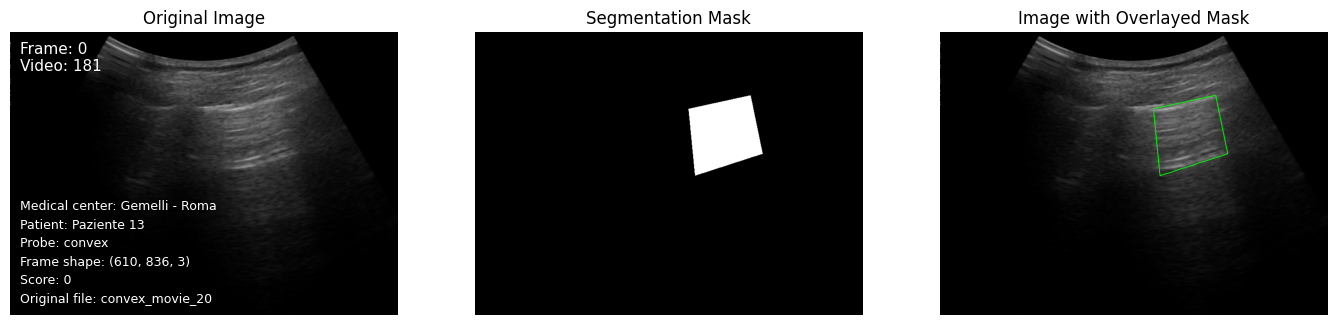

In [20]:
# display_frame_data(A, B) : A -> index of video | B -> index of frame
viewlib.display_frame_data(mat_dataset, 181, 0)

## Frames counts and resolutions study

In [21]:
# Get frame resolutions and patients for each video and the total number of frames
if not os.path.exists(pkl_frame_res_path):
    vresolutions, vpatients, vframes, nframes_total, nframes_linear, nframes_convex, nframes_unclassified, invalid_videos = preproclib.frames_res_study(mat_dataset, num_videos)

    # Create a dictionary to store the data
    pickle_resolutions_dict = {
        'resolutions': vresolutions,
        'patients': vpatients,
        'vframes': vframes,
        'nframes_total': nframes_total,
        'nframes_linear': nframes_linear,
        'nframes_convex': nframes_convex,
        'nframes_unclassified': nframes_unclassified,
        'invalid_videos': invalid_videos
    }

    # Save the data dictionary to a pickle file
    with open(pkl_frame_res_path, 'wb') as f:
        pickle.dump(pickle_resolutions_dict, f)

    # Print a message to indicate that the data has been saved
    print("\nStudy results has been saved to:", pkl_frame_res_path)
else:
    print("Study results already exists", pkl_frame_res_path)

Gathering info from mat dataset (frames=2154) : 100%|██████████| 230/230 [04:45<00:00,  1.24s/video]


Study results has been saved to: /Users/lorenzofederici/Univpm/Tesi/LUS-multitask-learning/data/new/iclus/frames-study.pkl


In [22]:
# Load data from the pickle file
with open(pkl_frame_res_path, 'rb') as f:
    data_dict = pickle.load(f)

# Access the data as needed
pckl_resolutions = data_dict['resolutions']
pckl_patients = data_dict['patients']
pckl_vframes = data_dict['vframes']
pckl_nframes_total = data_dict['nframes_total']
pckl_nframes_linear = data_dict['nframes_linear']
pckl_nframes_convex = data_dict['nframes_convex']
pckl_nframes_unclassified = data_dict['nframes_unclassified']
pckl_invalid_videos = data_dict['invalid_videos']

# Counter for videos that have frames with heterogeneous resolutions
varying_resolutions_count = 0

# Count the occurrences of each resolution
resolution_counts = Counter()

# Verify if frames have consistent resolutions within each video group
for video_name, resolutions_set in pckl_resolutions.items():
    if len(resolutions_set) != 1:
        varying_resolutions_count += 1
        print(f"Video '{video_name}' has varying resolutions: {resolutions_set}")
    else:
        resolution = resolutions_set.pop()
        resolution_counts[resolution] += 1

# Extract resolutions and their occurrences and sort them by descending occurrence
unique_resolutions, counts = zip(*resolution_counts.items())
sorted_resolutions, sorted_counts = zip(*sorted(zip(unique_resolutions, counts), key=lambda x: x[1], reverse=True))

# Verify if patients have videos with consistent resolutions within each center of research
patient_resolutions = {}
varying_patient_resolutions_count = 0
num_videos = 0
for video_name, (patient, center, frames) in pckl_patients.items():
    num_videos += 1
    resolutions_set = pckl_resolutions[video_name]
    patient_id = f"{patient}_{center}"
    if patient_id not in patient_resolutions:
        patient_resolutions[patient_id] = resolutions_set
    else:
        if patient_resolutions[patient_id] != resolutions_set:
            varying_patient_resolutions_count += 1
            print(f"Patient '{patient}' at '{center}' has varying resolutions across videos.")

# Print the number of videos and invalid ones
print(f"Videos: {len(pckl_vframes)}")
print(f"Invalid videos: {len(pckl_invalid_videos)}")

# Print the total number of frames, frames with linear, convex, and unclassified probes
print(f"\nTotal segmented frames: {pckl_nframes_total} ({round(pckl_nframes_total*100/total_frames_from_doc)}%)")
print(f"Frames with convex probes: {pckl_nframes_convex} ({round(pckl_nframes_convex*100/pckl_nframes_total)}%)")
print(f"Frames with linear probes: {pckl_nframes_linear} ({round(pckl_nframes_linear*100/pckl_nframes_total)}%)")
print(f"Frames unclassified: {pckl_nframes_unclassified}")

# Print the count of videos with varying resolutions and varying patient resolutions
print(f"\nVideos with varying resolutions: {varying_resolutions_count}")
print(f"Patients with varying resolutions across videos: {varying_patient_resolutions_count}")

Videos: 230
Invalid videos: 0

Total segmented frames: 2154 (4%)
Frames with convex probes: 1602 (74%)
Frames with linear probes: 552 (26%)
Frames unclassified: 0

Videos with varying resolutions: 0
Patients with varying resolutions across videos: 0


# **Dataset Conversion from MAT to HDF5**

In [23]:
# Function to save a single video data to the HDF5 file
def save_video_data(h5file, video_target_data, resuming, start_index):
    # get video data and metadata
    num_frames     = video_target_data.get_num_frames()
    video_name     = str(video_target_data.get_file_name())
    patient        = video_target_data.get_patient()
    medical_center = video_target_data.get_medical_center()
    source_file     = video_target_data.get_source_file_name()

    # Get the probe (it correspond to the h5 macro-group)
    probe = video_target_data.get_probe_type()
    group = h5file.require_group(probe)

    # Create the video group (making sure to handle the known duplicates)
    group_name = video_name

    video_group = group.require_group(group_name)

    # Ensure the existence of groups to contain frame and score data
    frames_group  = video_group.require_group('frames')
    masks_group   = video_group.require_group('masks')
    targets_group = video_group.require_group('targets')

    # Add 'patient', 'medical_center' and 'source_file' attributes to the video_group
    video_group.attrs['patient']        = patient
    video_group.attrs['medical_center'] = medical_center
    video_group.attrs['source_file']     = source_file

    for i in range(num_frames):
        frame, mask, score = video_target_data.get_data(i)

        frame_dset_name  = f'frame_{start_index + i}'
        mask_dset_name   = f'mask_{start_index + i}'
        target_dset_name = f'target_{start_index + i}'

        if not resuming:
            frames_group.create_dataset(frame_dset_name, data=frame, compression='gzip')
            masks_group.create_dataset(mask_dset_name, data=mask, compression='gzip')
            targets_group.create_dataset(target_dset_name, data=int(score))
        else:
            if frame_dset_name not in frames_group:
                frames_group.create_dataset(frame_dset_name, data=frame, compression='gzip')
            if mask_dset_name not in masks_group:
                masks_group.create_dataset(mask_dset_name, data=mask, compression='gzip')
            if target_dset_name not in targets_group:
                targets_group.create_dataset(target_dset_name, data=int(score))

    # Update the 'idx_start' and 'idx_end' attributes
    video_group.attrs['frame_idx_start'] = start_index
    video_group.attrs['frame_idx_end'] = start_index + (num_frames - 1)

    return start_index + num_frames

# Create the HDF5 file and save the dataset
def convert_matdataset_to_h5(mat_dataset, output_file, num_videos=None, checkpoint_idx_interval=10):
    # set the conversion conditions
    num_videos = num_videos if num_videos is not None else mat_dataset_len
    checkpoint_exists = os.path.exists(dataset_conv_checkpoint_path)
    h5_dataset_exists = os.path.exists(output_file)
    current_frame_index = 0
    current_video_index = 0
    resuming = False
    start = True

    # Load progress if checkpoint and dataset files exist
    if h5_dataset_exists and checkpoint_exists :
        with open(dataset_conv_checkpoint_path, 'r') as checkpoint:
            progress = checkpoint.read().split(',')
            if len(progress) == 2:
                current_frame_index = int(progress[0])
                current_video_index = int(progress[1]) + 1
                resuming = True

                print(f"Last checkpoint loaded successfully (resuming from the {current_video_index}th video).\n")
    else :
        # No progress file detected, can start a new conversion
        if os.path.exists(output_file):
            if input("There's already an .h5 dataset file, do you want to overwrite it? (y/N): ").strip().lower() == 'y':
                os.remove(output_file)
            else :
                start = False

    # Starting the conversion writing the HDF5 dataset in 'output_file'
    if start :
        with h5py.File(output_file, 'a' if resuming else 'w') as h5file:
            # Slicing the dataset if 'num_videos' is provided (creating a subset)
            mat_dataset_subset = islice(mat_dataset, num_videos) if num_videos != mat_dataset_len else mat_dataset

            # if it's a new conversion create the h5 macro-groups
            if not resuming :
                convex_group = h5file.create_group('convex')
                linear_group = h5file.create_group('linear')
            else :
                # Slice the dataset to resume from the next video
                mat_dataset_subset = islice(mat_dataset_subset, current_video_index, None)

            # Iterate through the videos of the mat dataset
            with tqdm(total=num_videos, desc="Converting mat dataset to HDF5", dynamic_ncols=True, unit="video", initial=current_video_index) as pbar_outer:
                for video_index, video_target_data in enumerate(mat_dataset_subset, start=current_video_index):
                    # Save the video and target data into the h5 dataset
                    current_frame_index = save_video_data(h5file, video_target_data, resuming, current_frame_index)

                    # Update the progress bar
                    pbar_outer.update(1)
                    pbar_outer.set_postfix(file=f"{os.path.getsize(output_file) / (1024.0 ** 3):.2f} GB", frames=current_frame_index)

                    # Save the checkpoint every 'checkpoint_idx_interval' videos
                    if video_index % checkpoint_idx_interval == 0:
                        with open(dataset_conv_checkpoint_path, 'w') as checkpoint:
                            checkpoint.write(f"{current_frame_index},{video_index}")

                    # Delete checkpoint file when conversion is completed
                    if pbar_outer.n == num_videos:
                        os.remove(dataset_conv_checkpoint_path)
                        break

        # Print a message to indicate that the data has been saved
        print("\nDataset converted and saved to:", dataset_h5_path)

In [24]:
# Launch the conversion
preproclib.convert_matdataset_to_h5(mat_dataset, dataset_h5_path, dataset_conv_checkpoint_path)

Converting mat dataset to HDF5:   0%|          | 0/230 [00:00<?, ?video/s]/var/folders/6d/csnj1qws0cx55lnb9fw82mrc0000gn/T/ipykernel_62461/1523028023.py:63: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint64 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  scores[scores < 0] = -1
/var/folders/6d/csnj1qws0cx55lnb9fw82mrc0000gn/T/ipykernel_62461/1523028023.py:64: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -1 to uint64 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  scores[scores > 3] = -1
Converting mat dataset to HDF5: 100%|██████████| 230/230 [09:32<00:00,  2.49s/video, file=1.20 GB, frames=2154]


Dataset converted and saved to: /Users/lorenzofederici/Univpm/Tesi/LUS-multitask-learning/data/new/iclus/dataset.h5
